In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Original Data

In [126]:
df = pd.read_csv('fredgraph.csv')
df1 = pd.read_csv('cpiCars.csv')
df1.rename(columns={'CPIAUCSL_PC1':'INFLATION'}, inplace=True)
df =pd.merge(df, df1, on='DATE')
df

,DATE,TOTALSA,UNRATE,FEDFUNDS,INFLATION
0,1976-01-01,12.814,7.9,4.87,6.69216
1,1976-02-01,13.34,7.7,4.77,6.27376
2,1976-03-01,13.378,7.6,4.84,6.06061
3,1976-04-01,13.223,7.7,4.82,5.84906
4,1976-05-01,12.962,7.4,5.29,6.21469
...,...,...,...,...,...
573,2023-10-01,15.919,3.8,5.33,3.24579
574,2023-11-01,16.016,3.7,5.33,3.13948
575,2023-12-01,16.574,3.7,5.33,3.32316
576,2024-01-01,15.427,3.7,5.33,3.10598


In [127]:
df.describe()

,FEDFUNDS,INFLATION
count,578.000000,578.000000
mean,4.661851,3.712138
std,3.984965,2.774224
min,0.050000,-1.958760
25%,1.150000,2.001030
50%,4.760000,3.011315
75%,6.662500,4.429303
max,19.100000,14.592270


In [128]:

df['FEDFUNDS'] = pd.to_numeric(df['FEDFUNDS'], errors='coerce')
df['UNRATE'] = pd.to_numeric(df['UNRATE'], errors='coerce')
df['TOTALSA'] = pd.to_numeric(df['TOTALSA'], errors='coerce')

df.dropna(subset=['FEDFUNDS', 'UNRATE', 'TOTALSA', 'INFLATION'], inplace=True)

x = df[['FEDFUNDS', 'UNRATE','INFLATION']] 
y = df['TOTALSA'] 
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                TOTALSA   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     313.5
Date:                Thu, 16 May 2024   Prob (F-statistic):          1.80e-120
Time:                        20:31:11   Log-Likelihood:                -1005.8
No. Observations:                 578   AIC:                             2020.
Df Residuals:                     574   BIC:                             2037.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5982      0.222     97.505      0.0

In [129]:
vif = pd.DataFrame()
vif["Variable"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif

,Variable,VIF
0,const,14.815263
1,FEDFUNDS,1.957278
2,UNRATE,1.015139
3,INFLATION,1.936764


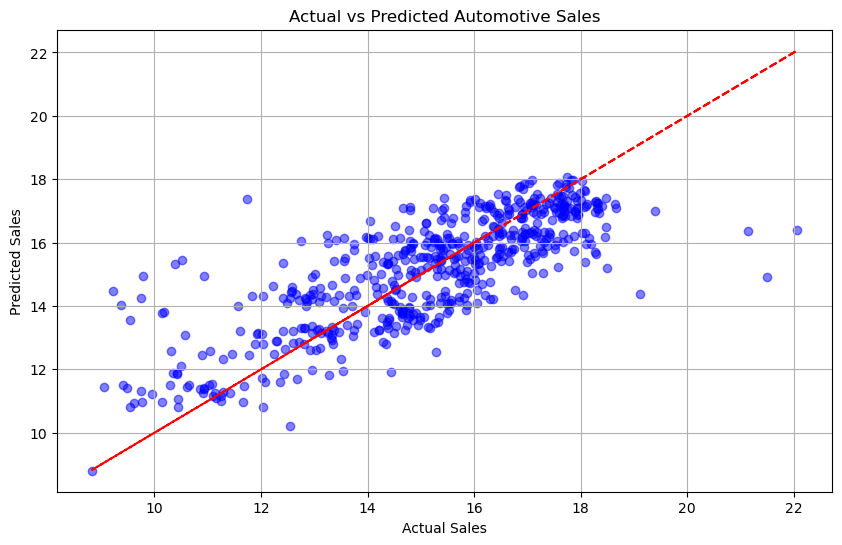

In [130]:
predicted_values = model.predict(x)

plt.figure(figsize=(10, 6))
plt.scatter(y, predicted_values, color='blue', alpha=0.5)
plt.plot(y, y, color='red', linestyle='--')
plt.title('Actual vs Predicted Automotive Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.show()

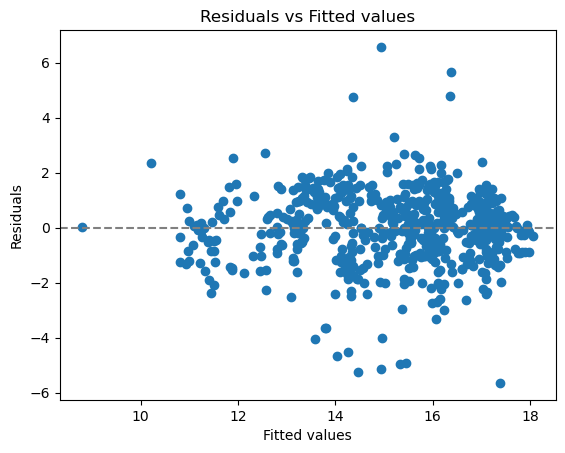

In [131]:
residuals = model.resid

plt.scatter(predicted_values, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

# Arima

In [132]:

dependent_variable = df['TOTALSA']  
independent_variables = df[['FEDFUNDS', 'UNRATE', 'INFLATION']] 


arima_model = ARIMA(dependent_variable, order=(1, 1, 0)) 
arima_result = arima_model.fit()

print(arima_result.summary())



                               SARIMAX Results                                
Dep. Variable:                TOTALSA   No. Observations:                  578
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -802.232
Date:                Thu, 16 May 2024   AIC                           1608.465
Time:                        20:31:11   BIC                           1617.180
Sample:                             0   HQIC                          1611.863
                                - 578                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2453      0.019    -12.819      0.000      -0.283      -0.208
sigma2         0.9443      0.025     38.221      0.000       0.896       0.993
Ljung-Box (L1) (Q):                   2.25   Jarque-

In [133]:


X = sm.add_constant(independent_variables)  
y = arima_result.resid  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


regression_model = sm.OLS(y_train, X_train)
regression_results = regression_model.fit()

print(regression_results.summary())


y_pred = regression_results.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.207
Date:                Thu, 16 May 2024   Prob (F-statistic):              0.307
Time:                        20:31:11   Log-Likelihood:                -707.17
No. Observations:                 462   AIC:                             1422.
Df Residuals:                     458   BIC:                             1439.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2613      0.206     -1.268      0.2

## first and second best arima parameters for r squared

In [135]:

p_values = range(5) 
d_values = range(3)  
q_values = range(5)  

# variables to store best parameters and performance
best_r_squared = -float('inf')
second_best_r_squared = -float('inf')
best_params = None
second_best_params = None

# Iterate over parameter combinations
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                arima_model = ARIMA(dependent_variable, order=(p, d, q))
                arima_result = arima_model.fit()

                
                X = sm.add_constant(independent_variables)  
                y = arima_result.resid  

                # Split data into training and testing sets
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                regression_model = sm.OLS(y_train, X_train)
                regression_results = regression_model.fit()

                
                r_squared = r2_score(y_test, regression_results.predict(X_test))

                # Update best and second-best parameters if current combination improves performance
                if r_squared > best_r_squared:
                    second_best_r_squared = best_r_squared
                    second_best_params = best_params
                    best_r_squared = r_squared
                    best_params = (p, d, q)
                elif r_squared > second_best_r_squared:
                    second_best_r_squared = r_squared
                    second_best_params = (p, d, q)
            except:
                continue

print("Best ARIMA parameters (p, d, q):", best_params)
print("Best R-squared:", best_r_squared)

print("Second Best ARIMA parameters (p, d, q):", second_best_params)
print("Second Best R-squared:", second_best_r_squared)


c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\base\mode

Best ARIMA parameters (p, d, q): (0, 0, 0)
Best R-squared: 0.6729963708133562
Second Best ARIMA parameters (p, d, q): (0, 0, 1)
Second Best R-squared: 0.4778792280021056


c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [136]:

dependent_variable = df['TOTALSA']  
independent_variables = df[['FEDFUNDS', 'UNRATE', 'INFLATION']] 

arima_model = ARIMA(dependent_variable, order=(0, 0, 1))  
arima_result = arima_model.fit()

# Check ARIMA model summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                TOTALSA   No. Observations:                  578
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1057.781
Date:                Thu, 16 May 2024   AIC                           2121.561
Time:                        20:31:36   BIC                           2134.640
Sample:                             0   HQIC                          2126.661
                                - 578                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.1497      0.113    134.631      0.000      14.929      15.370
ma.L1          0.7329      0.027     27.506      0.000       0.681       0.785
sigma2         2.2726      0.115     19.758      0.0

In [137]:

X = sm.add_constant(independent_variables)  
y = arima_result.resid  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regression_model = sm.OLS(y_train, X_train)
regression_results = regression_model.fit()

print(regression_results.summary())


y_pred = regression_results.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     114.5
Date:                Thu, 16 May 2024   Prob (F-statistic):           2.59e-55
Time:                        20:31:36   Log-Likelihood:                -703.91
No. Observations:                 462   AIC:                             1416.
Df Residuals:                     458   BIC:                             1432.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6179      0.205     17.680      0.0

In [138]:
error_term = regression_results.resid
rmse = np.sqrt((error_term ** 2).mean())
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1.1103529177226727


# Log transformation

In [139]:
dfLog = df[['TOTALSA', 'FEDFUNDS', 'UNRATE', 'INFLATION']].apply(np.log)
dfLog

,TOTALSA,FEDFUNDS,UNRATE,INFLATION
0,2.550538,1.583094,2.066863,1.900937
1,2.590767,1.562346,2.041220,1.836376
2,2.593612,1.576915,2.028148,1.801810
3,2.581958,1.572774,2.041220,1.766281
4,2.562022,1.665818,2.001480,1.826916
...,...,...,...,...
573,2.767513,1.673351,1.335001,1.177359
574,2.773588,1.673351,1.308333,1.144057
575,2.807835,1.673351,1.308333,1.200916
576,2.736119,1.673351,1.308333,1.133329


In [140]:
dfLog.dropna(subset=['FEDFUNDS', 'UNRATE', 'TOTALSA', 'INFLATION'], inplace=True)
x = dfLog[['FEDFUNDS', 'UNRATE','INFLATION']]
y = dfLog['TOTALSA']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                TOTALSA   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     219.4
Date:                Thu, 16 May 2024   Prob (F-statistic):           4.26e-94
Time:                        20:31:36   Log-Likelihood:                 482.19
No. Observations:                 564   AIC:                            -956.4
Df Residuals:                     560   BIC:                            -939.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4163      0.029    117.717      0.0

In [141]:
vif = pd.DataFrame()
vif["Variable"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif

,Variable,VIF
0,const,44.534554
1,FEDFUNDS,1.433180
2,UNRATE,1.033344
3,INFLATION,1.411445


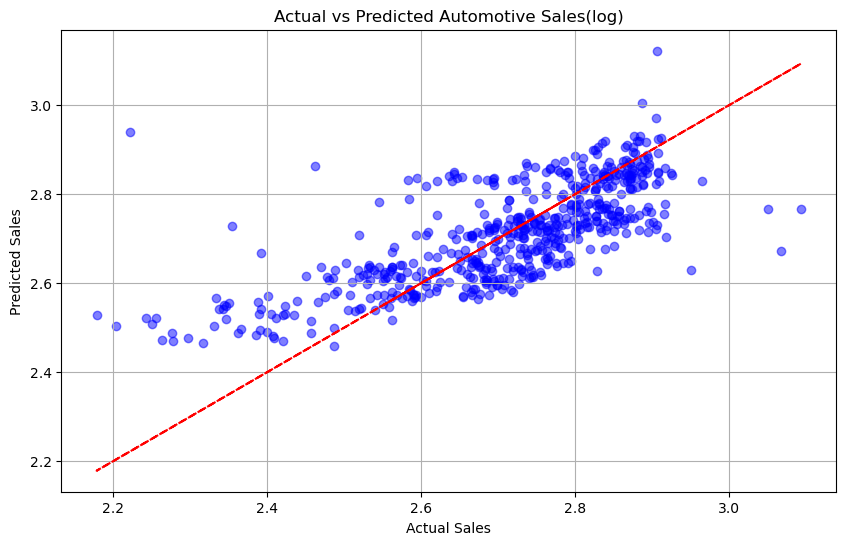

In [142]:
predicted_values = model.predict(x)

plt.figure(figsize=(10, 6))
plt.scatter(y, predicted_values, color='blue', alpha=0.5)
plt.plot(y, y, color='red', linestyle='--')
plt.title('Actual vs Predicted Automotive Sales(log)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.show()

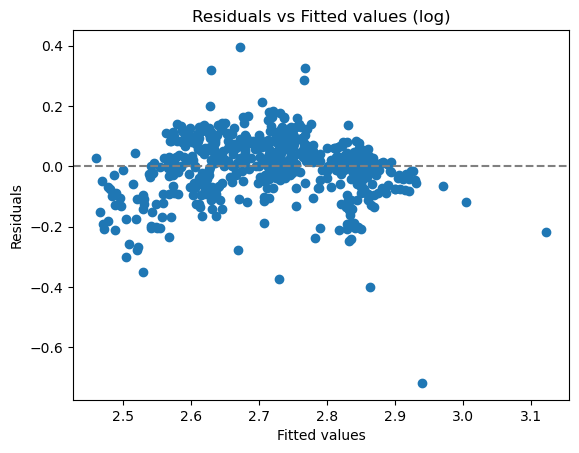

In [143]:
residuals = model.resid

# Plot residuals against predicted values
plt.scatter(predicted_values, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values (log)')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

In [147]:

dependent_variable = dfLog['TOTALSA']  
independent_variables = dfLog[['FEDFUNDS', 'UNRATE', 'INFLATION']]

arima_model = ARIMA(dependent_variable, order=(0, 0, 1)) 
arima_result = arima_model.fit()

print(arima_result.summary())

c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                TOTALSA   No. Observations:                  564
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 491.161
Date:                Thu, 16 May 2024   AIC                           -976.322
Time:                        20:32:32   BIC                           -963.317
Sample:                             0   HQIC                          -971.245
                                - 564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7112      0.008    325.127      0.000       2.695       2.728
ma.L1          0.7339      0.025     29.086      0.000       0.684       0.783
sigma2         0.0102      0.001     18.698      0.0

c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [148]:


X = sm.add_constant(independent_variables)  
y = arima_result.resid  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regression_model = sm.OLS(y_train, X_train)
regression_results = regression_model.fit()

print(regression_results.summary())

y_pred = regression_results.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     93.61
Date:                Thu, 16 May 2024   Prob (F-statistic):           5.05e-47
Time:                        20:32:36   Log-Likelihood:                 526.46
No. Observations:                 451   AIC:                            -1045.
Df Residuals:                     447   BIC:                            -1028.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3773      0.025     15.398      0.0

In [149]:

p_values = range(5)  
d_values = range(3)  
q_values = range(5)  


best_r_squared = -float('inf')
second_best_r_squared = -float('inf')
best_params = None
second_best_params = None

# Iterate over parameter combinations
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                arima_model = ARIMA(dependent_variable, order=(p, d, q))
                arima_result = arima_model.fit()

                X = sm.add_constant(independent_variables)  
                y = arima_result.resid  # Use ARIMA residuals as the adjusted dependent variable

               
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                regression_model = sm.OLS(y_train, X_train)
                regression_results = regression_model.fit()

                r_squared = r2_score(y_test, regression_results.predict(X_test))

                # Update best and second-best parameters if current combination improves performance
                if r_squared > best_r_squared:
                    second_best_r_squared = best_r_squared
                    second_best_params = best_params
                    best_r_squared = r_squared
                    best_params = (p, d, q)
                elif r_squared > second_best_r_squared:
                    second_best_r_squared = r_squared
                    second_best_params = (p, d, q)
            except:
                continue

print("Best ARIMA parameters (p, d, q):", best_params)
print("Best R-squared:", best_r_squared)

print("Second Best ARIMA parameters (p, d, q):", second_best_params)
print("Second Best R-squared:", second_best_r_squared)

c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA parameters (p, d, q): (0, 0, 0)
Best R-squared: 0.46572621553208726
Second Best ARIMA parameters (p, d, q): (0, 0, 1)
Second Best R-squared: 0.3374022281426493


c:\Users\Chris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


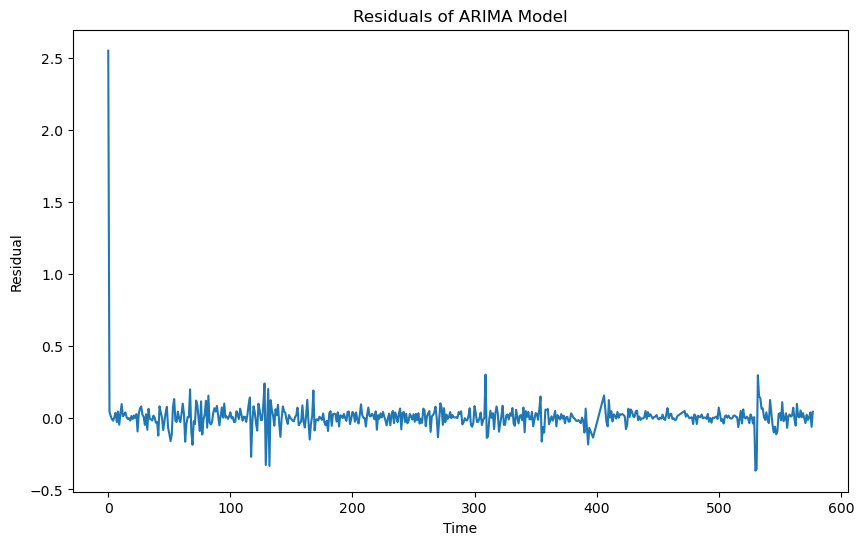

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(arima_result.resid)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()